# Florence 2 Test

https://huggingface.co/microsoft/Florence-2-base

In [41]:
import requests
import time

import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import AutoProcessor, AutoModelForCausalLM 

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

In [3]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
prompt = "<OD>"

In [5]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

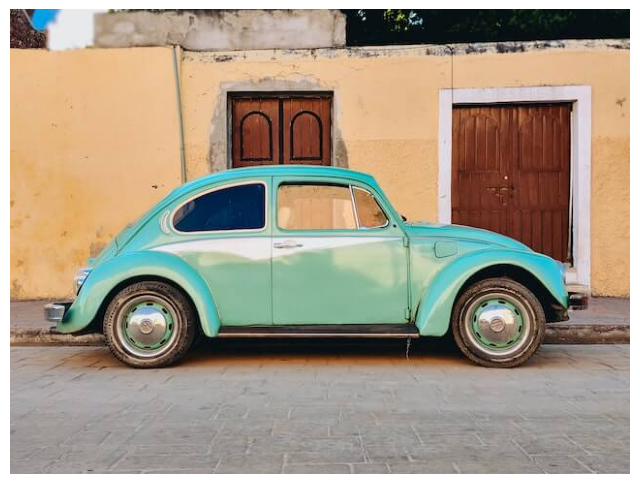

In [9]:
# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
#plt.title("Image")
plt.show()

In [6]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

print(parsed_answer)

{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [272.32000732421875, 241.67999267578125, 303.67999267578125, 247.4399871826172], [454.0799865722656, 276.7200012207031, 553.9199829101562, 370.79998779296875], [96.31999969482422, 280.55999755859375, 198.0800018310547, 371.2799987792969]], 'labels': ['car', 'door handle', 'wheel', 'wheel']}}


In [10]:
parsed_answer['<OD>']

{'bboxes': [[34.23999786376953,
   160.0800018310547,
   597.4400024414062,
   371.7599792480469],
  [272.32000732421875,
   241.67999267578125,
   303.67999267578125,
   247.4399871826172],
  [454.0799865722656,
   276.7200012207031,
   553.9199829101562,
   370.79998779296875],
  [96.31999969482422,
   280.55999755859375,
   198.0800018310547,
   371.2799987792969]],
 'labels': ['car', 'door handle', 'wheel', 'wheel']}

In [11]:
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

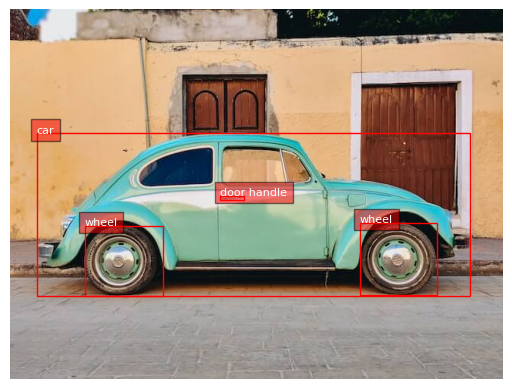

In [14]:
plot_bbox(image, parsed_answer['<OD>'])

In [50]:
def run_example(task_prompt, text_input=None):
    start_time = time.perf_counter()  # Start timing
    
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))

    print(parsed_answer)

    end_time = time.perf_counter()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f" \n[INFO] ==> Florence-2-base ({task_prompt}), took {elapsed_time:.1f} seconds to execute.\n")
    
    return parsed_answer

In [51]:
prompt = "<CAPTION>"
results = run_example(prompt)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}
 
[INFO] ==> Florence-2-base (<CAPTION>), took 15.6 seconds to execute.



In [52]:
prompt = "<DETAILED_CAPTION>"
results = run_example(prompt)

{'<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}
 
[INFO] ==> Florence-2-base (<DETAILED_CAPTION>), took 23.2 seconds to execute.



In [53]:
prompt = "<MORE_DETAILED_CAPTION>"
results = run_example(prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is a light blue color with a white stripe running along the side. It has a round body and a small rear window. The wheels are silver with black rims. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}
 
[INFO] ==> Florence-2-base (<MORE_DETAILED_CAPTION>), took 40.5 seconds to execute.



In [54]:
task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
results = run_example(task_prompt, text_input="A green car parked in front of a yellow building.")

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[35.52000045776367, 159.1199951171875, 582.719970703125, 375.1199951171875], [0.3199999928474426, 0.23999999463558197, 639.0399780273438, 305.03997802734375]], 'labels': ['A green car', 'a yellow building']}}
 
[INFO] ==> Florence-2-base (<CAPTION_TO_PHRASE_GROUNDING>), took 16.6 seconds to execute.



In [55]:
results['<CAPTION_TO_PHRASE_GROUNDING>']

{'bboxes': [[35.52000045776367,
   159.1199951171875,
   582.719970703125,
   375.1199951171875],
  [0.3199999928474426,
   0.23999999463558197,
   639.0399780273438,
   305.03997802734375]],
 'labels': ['A green car', 'a yellow building']}

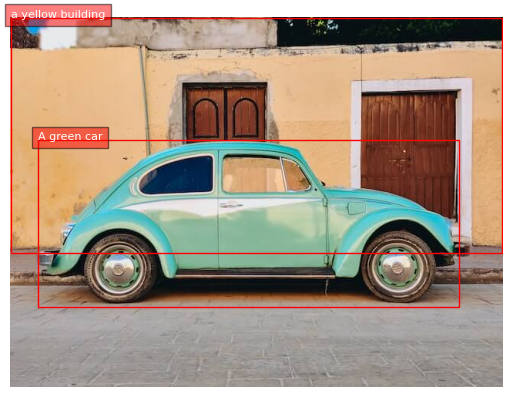

In [56]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])